# VS Code Event Performance

First, let's look at how events are used. I initially hypothesized we'd have a bimodal distribution between listeners with a small number of events, and ones with large number of events.

In reality, it's much closer to a power-law distribution. The plurality of event emitters have no listeners at all, and second most common is a single listener. This data was collected after VS Code started up with an editor open:

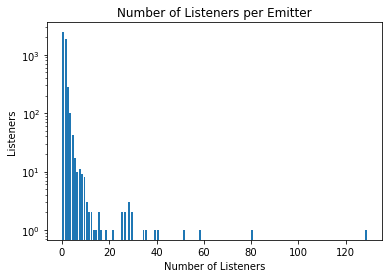

In [7]:
import json
import matplotlib.pyplot as plt

with open('./boot.json') as f:
  data = json.load(f)

fig, ax = plt.subplots(facecolor='w')
ax.hist(data['numListeners'], bins=range(min(data['numListeners']), max(data['numListeners']) + 2, 1), rwidth=0.8)
ax.set_xlabel('Number of Listeners')
ax.set_ylabel('Listeners')
ax.set_title('Number of Listeners per Emitter')
ax.set_yscale('log')
plt.show()


We can also estimate how long was spent in the delivery mechanics during boot. This is the time to create the delivery queue, not call each individual function, so it slightly **underestimates** the actual time.

In [3]:
total = 0
emissions = 0
for d in data['eventRate']:
  total += d['spent'] - d['deliverySpent']
  emissions += d['emissions']
print('Stats for the first', len(data['eventRate']), 'seconds of the editor:')
print('Time spent in emitter overhead (ms)', round(total, 2))
print('Total number of event emissions:', emissions)

Stats for the first 13 seconds of the editor:
Time spent in emitter overhead (ms) 33.0
Total number of event emissions: 13882


Finally, let's look at memory usage once the editor is in a steady opened state. This is counting the direct utilization of the Emitters and its linked list nodes.

From a heap snapshot, I manually tallied memory usage per for emitters, which comes to a total usage of:

In [4]:
zero_listener_emitter = 76
linked_list_overhead = 24
bytes_per_emitter = 24
memory = 0
for n in data['numListeners']:
    if n == 0:
      memory += zero_listener_emitter
    else:
      memory += zero_listener_emitter + linked_list_overhead + n * bytes_per_emitter
print("Memory usage:", memory / 1024, "KB")

Memory usage: 512.8671875 KB


---

Now let's look at new `evt` style events as implemented in [PR #185889](https://github.com/microsoft/vscode/pull/185889). This a closer examinaton based on analyzing the .cpuprofile while starting the editor several times with the old log, and then the new logic.

The script that extracted this data can be found `profile-extractor.js`. Each CPU profile has a list of `nodes`, which are stack frames containing zero or more child frame `nodes`, and the `samples` array that indicates which node was at the top of the stack at that moment for a duration given by `timeDeltas[i]`. To figure out how much time was spent in the event code, we count all code that was called in or by `event.js`, until we get to a "deliver" or "invoke" method, which are the methods used by the old and new code to call the business logic contained in each listener.

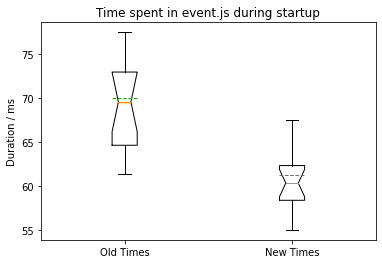

The new times are faster than the old times
Chance this is a statistically significantly different from "old times": 99.98%
Median time 70.0252 -> 61.2079375


In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

with open('./old.json') as f:
  old_times = json.load(f)

with open('./new.json') as f:
  new_times = json.load(f)

data = [old_times, new_times]
fig, ax = plt.subplots(facecolor='w')
ax.boxplot(data, showfliers=False, showmeans=True, meanline=True, labels=['Old Times', 'New Times'], notch=True)
ax.set_ylabel('Duration / ms')
ax.set_title('Time spent in event.js during startup')
plt.savefig('event_analysis.png') # save the plot image to a file
plt.show()

t_stat, p_val = ttest_ind(old_times, new_times)
diff_perc = round((1 - p_val) * 100, 2)
if t_stat > 0:
  print("The new times are faster than the old times")
print(f'Chance this is a statistically significantly different from "old times": {diff_perc}%')
print(f'Median time {np.mean(old_times)} -> {np.mean(new_times)}')

It appears the new event system shaved 10ms or so off startup time. Neat!